# Detección de anomalias
**Proyecto:** 3  
**Equipo:**  
    -Ibsan Otniel Morales Yepiz  
    -Hugo de Jesús Valenzuela Chaparro  
    -Héctor Rodríguez Domínguez  
    
### Descripción de Datos
   -El dataset empleado para este proyecto se obutvo de la plataforma de Kaggle en el siguiente enlace: https://www.kaggle.com/tangodelta/api-access-behaviour-anomaly-dataset
    
   -El dataset contine las sisguientes columnas:  
   <ul>
    <li>**inter_api_access_duration(sec):** Intervalo de tiempo entre dos accesos consecutivos en la sesión de un usuario  </li>
    <li>**api_access_uniqueness:** La proporción de diferentes APIs utilzadas con relación a las APIs utilizadas en la sesión de un usuario  </li>
    <li>**sequence_length(count):** Promedio de llamadas que un usuario hace en una sesión  </li>
    <li>**vsession_duration(min):** Duración de una sesión en minutos   </li>
    <li>**ip_type:** Tipo de ip de donde proviene el usuario  </li>
    <li>**behavior:** subtipo de comportamiento  </li>
    <li>**behavior_type:** Tipo de comportamiento  </li>
    <li>**num_sessions:** Numeor de sesiónes con diferente id de sesión  </li>
    <li>**num_users:** NUmero de usuarios realizando el mismo tipo de llamadas a la API  </li>
    <li>**num_unique_apis:** Número de APIs distintas en el mismo grupo de ocmportamiento  </li>
    <li>**source:** Origen de la información  </li>
    </ul>
    

### Importando librerias

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import seaborn as sns
from pandas_profiling import ProfileReport 
from sklearn.neighbors import LocalOutlierFactor
import sweetviz

### Lectura y preparación de datos

In [2]:
#Read file
df = pd.read_csv("data/remaining_behavior_ext.csv")

#Rename columns according to our preference
df.rename(
    columns={"inter_api_access_duration(sec)": "access_duration", "api_access_uniqueness": "access_uniqueness",
             "sequence_length(count)": "session_calls", "vsession_duration(min)": "session_duration" }, 
    inplace=True
)

#Pop useless columns for our intention
df.pop("ip_type")
df.pop("behavior")
df.pop("num_sessions")
df.pop("num_unique_apis")
df.pop("source")

#we remove unnamed column
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

#We assign a nuemrical value to behavior_type column
#df["behavior_type"].replace({"attack": 1, "bot": 2, "normal": 3, "outlier": 4}, inplace=True)

#We transform minutes to seconds in order to normalize the DF
df["session_duration"] = 60 * df["session_duration"]


df.head()

,access_duration,access_uniqueness,session_calls,session_duration,behavior_type,num_users
0,7.010387,0.419355,31.0,782400,outlier,1.0
1,51.419393,0.252336,107.0,19806780,outlier,1.0
2,25.860775,0.275000,40.0,3723960,outlier,1.0
3,0.205909,0.818182,11.0,8160,outlier,1.0
4,0.122125,0.812500,16.0,7080,outlier,1.0


### Análisis exploratorio
En esta sección se revisa la información de la estrucutra general de nuestro dataframe, asi como datos generales de este.  

**La forma de nuestro dataframe:** 

In [3]:
df.shape

(34562, 6)

**Tipos de datos:**  

In [4]:
df.dtypes

access_duration      float64
access_uniqueness    float64
session_calls        float64
session_duration       int64
behavior_type         object
num_users            float64
dtype: object

**Valores perdidos, repetidos y NaN:**  

In [5]:
#Valores vacios
df.isnull().sum()

access_duration      5
access_uniqueness    5
session_calls        0
session_duration     0
behavior_type        0
num_users            0
dtype: int64

In [7]:
#We remove rows with null values
df = df.dropna()
print("Dataset despues de quitar valores nulos")
df.isnull().sum()

Dataset despues de quitar valores nulos


access_duration      0
access_uniqueness    0
session_calls        0
session_duration     0
behavior_type        0
num_users            0
dtype: int64

In [8]:
#Eliminar valores NaN
df.dropna(inplace=True)

#Valores duplicados
print(df.duplicated().sum())

1179


In [9]:
#Eliminamos filas con valores duplicados
df.drop_duplicates(keep='last',inplace=True)
print(df.duplicated().sum())

0


**Mapa de correlación**  
En esta sección se muestra un mapa de calor, donde podemos observar que no hay una correlación importante entre las diferentes columnas del dataset


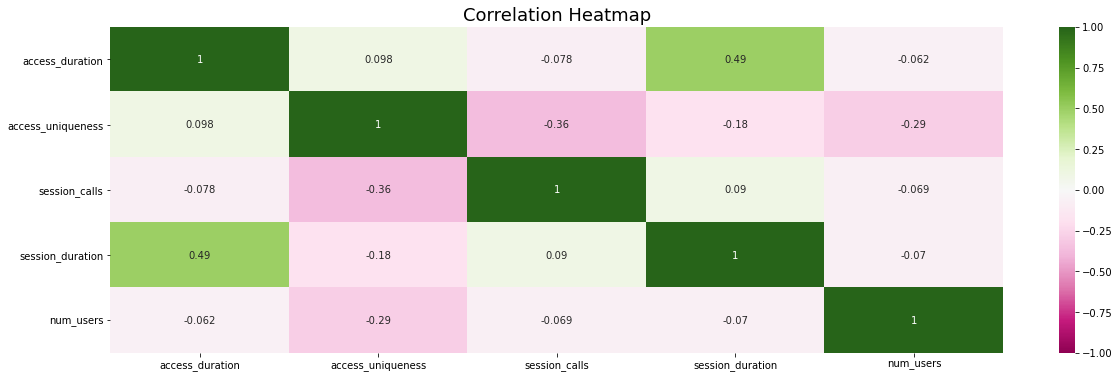

In [10]:
plt.figure(figsize=(20,6))
hm = sns.heatmap(df.corr(),vmin=-1, vmax=1, annot=True,cmap='PiYG')
hm.set_title('Correlation Heatmap',  fontdict={'fontsize':18});
plt.show()

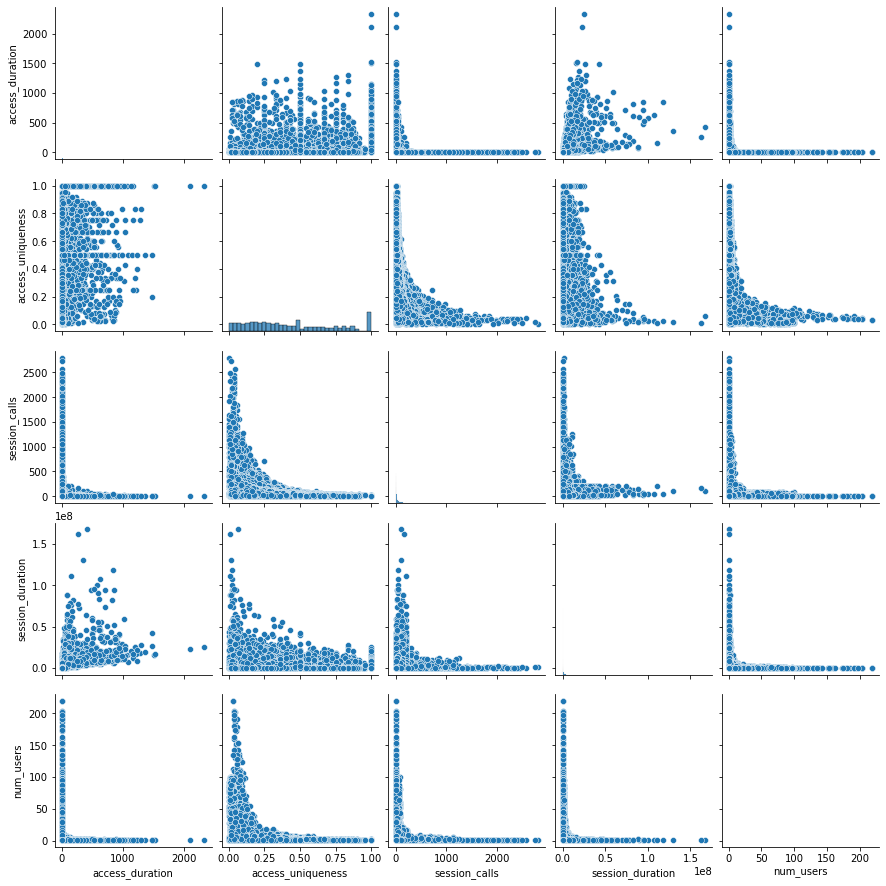

In [11]:
sns.pairplot(df) 
plt.show()

#### Descripción de datos

In [12]:
df.groupby('behavior_type').agg(['mean','min', 'max'])

access_duration                        access_uniqueness  \
                         mean       min          max              mean   
behavior_type                                                            
attack              34.116884  5.522434   112.015222          0.284409   
bot                 28.081147  0.000000  1483.934200          0.258468   
normal               8.481570  0.000000   889.360833          0.246879   
outlier             25.346105  0.000000  2333.627333          0.518783   

                                  session_calls                \
                    min       max          mean   min     max   
behavior_type                                                   
attack         0.075472  0.846154    115.818182  13.0   200.0   
bot            0.003356  1.000000     30.845778   1.0   596.0   
normal         0.000714  0.900000     31.263716   1.5  1253.5   
outlier        0.000714  1.000000     80.438993   1.0  2800.0   

              session_duration                     num_users              
                          mean     min        max       mean  min    max  
behavior_type                                                             
attack            9.582289e+06  457920   12834720   1.090909  1.0    3.0  
bot               2.747629e+06       0   75991320  14.749538  1.0  219.0  
normal            9.918520e+05       0   88603680   9.394684  2.0  100.0  
outlier           2.040443e+06       0  167251800   1.000000  1.0    1.0

#### Creación de perfil con "sweetviz"

In [ ]:
df_profile = ProfileReport(
    df, 
    explorative=True,
    title='Comportamiento de dataframe', 
    html={'style':{'full_width':False}}
) 

df_profile.to_file("profile.html")

B_profile = sweetviz.analyze(df)
B_profile.show_html("profile.html")


#### Información general sobre las columnas del dataset

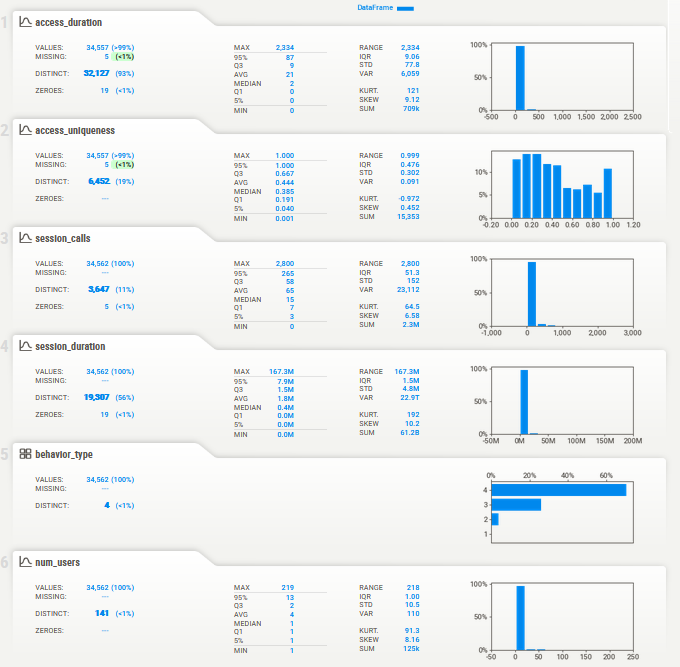

#### Basados en la información previamente obtenida en el análisis del dataset, queremos detectar las anomalias en el tiempo que transcurre entre cada llamada a una API, para determinar si es un bot.


#### Local Outlier factor

El factor atípico local es un algoritmo propuesto para encontrar puntos de datos anómalos midiendo la desviación local de un punto de datos dado con respecto a sus vecinos.

In [19]:
df["behavior_type"].replace({"attack": 1, "bot": 2, "normal": 3, "outlier": 4}, inplace=True)

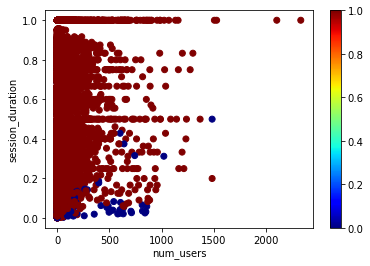

In [21]:
clf = LocalOutlierFactor(n_neighbors=100)
estimado_LOF = clf.fit_predict(df)

plt.scatter(x=df.iloc[:,0], y=df.iloc[:,1], c=np.where(estimado_LOF > 0.0,1,0), cmap='jet')
#plt.scatter(x=X[:,0], y=X[:,1], c=estimado_LOF, cmap='jet')
plt.xlabel("num_users")
plt.ylabel("session_duration")
plt.colorbar()
plt.show()

In [22]:
np.where(estimado_LOF > 0.0,1,0).mean()

0.9845407154413086

#### Isolation Forest
Es una método no supervisado para identificar anomalías (outliers) cuando los datos no están etiquetados, es decir, no se conoce la clasificación real (anomalía - no anomalía) de las observaciones. 

Su funcionamiento está inspirado en el algoritmo de clasificación y regresión Random Forest

In [ ]:
random_state = np.random.RandomState(43)
model=IsolationForest(n_estimators=50, contamination=float(0.9), warm_start=True, random_state=random_state)

#model = IsolationForest(n_estimators=50, warm_start=True)
model.fit(df[['access_duration']])

df['scores'] = model.decision_function(df[['access_duration']])

df['anomaly_score'] = model.predict(df[['access_duration']])

#print(df[df['anomaly_score']==-1].head(20))
#df[df['anomaly_score']==-1].tail(20) 

anomaly_count = df.shape[0]
    
accuracy = 100*list(df['anomaly_score']).count(-1)/anomaly_count
#accuracy = df[df['anomaly_score']==-1].head()
print("Accuracy of the model:", accuracy)

plt.scatter(x=df.iloc[:,0], y=df.iloc[:,1], c=df['scores'], cmap='jet')
plt.colorbar()
plt.show()

#### Conclusiones

Como se puede observar, este dataset presenta casos muy especiales donde los valores cercanos al 0 se presentan como valores anomales fdebido a la rapides de acceso entre las aplicaciones

Asimismo no existe mucha correlacion entre las diferente variables, por lo cual se decidio trabajar con la columna de "access_duration", la cual tiene una mayor correlación con "session_duration" como se muestra en los pair plots.

Contemplando los resultados entre ambos metodos, se puede observar que el mejor resultado se obtiene a traves del uso del Local Outlier factor. debido a que se ajusta mejor por los vecinos y cercania de los valores en de